The first step in every data analysis process is to - understanding what question is driving the analysis and that is the first thing that we should be focussed on - define the goals of analysis 

In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.getOrCreate()

In [2]:
print(spark.version)

2.4.0


In [3]:
import sys

print(sys.version_info)

sys.version_info(major=3, minor=6, micro=5, releaselevel='final', serial=0)


### Loading data

In [4]:
df = spark.read.csv('2017_StPaul_MN_Real_Estate.csv', inferSchema=True, header=True)
print(df.columns)

['No.', 'MLSID', 'StreetNumberNumeric', 'streetaddress', 'STREETNAME', 'PostalCode', 'StateOrProvince', 'City', 'SalesClosePrice', 'LISTDATE', 'LISTPRICE', 'LISTTYPE', 'OriginalListPrice', 'PricePerTSFT', 'FOUNDATIONSIZE', 'FENCE', 'MapLetter', 'LotSizeDimensions', 'SchoolDistrictNumber', 'DAYSONMARKET', 'offmarketdate', 'Fireplaces', 'RoomArea4', 'roomtype', 'ROOF', 'RoomFloor4', 'PotentialShortSale', 'PoolDescription', 'PDOM', 'GarageDescription', 'SQFTABOVEGROUND', 'Taxes', 'RoomFloor1', 'RoomArea1', 'TAXWITHASSESSMENTS', 'TAXYEAR', 'LivingArea', 'UNITNUMBER', 'YEARBUILT', 'ZONING', 'STYLE', 'ACRES', 'CoolingDescription', 'APPLIANCES', 'backonmarketdate', 'ROOMFAMILYCHAR', 'RoomArea3', 'EXTERIOR', 'RoomFloor3', 'RoomFloor2', 'RoomArea2', 'DiningRoomDescription', 'BASEMENT', 'BathsFull', 'BathsHalf', 'BATHQUARTER', 'BATHSTHREEQUARTER', 'Class', 'BATHSTOTAL', 'BATHDESC', 'RoomArea5', 'RoomFloor5', 'RoomArea6', 'RoomFloor6', 'RoomArea7', 'RoomFloor7', 'RoomArea8', 'RoomFloor8', 'Bedroo

<font color='red'>The parameter `inferSchema` helps to infer data types of the features automatically. If it is not set to true, Spark assign `String` data types to all the variables<>

### Verifying data load

In [5]:
def check_load(df, num_records, num_columns):
    # Takes a dataframe and compares record and column counts to input
    # Message to return if the critera below aren't met
    message = 'Validation Failed'
    
    # Check number of records
    if num_records == df.count():
        
        # Check number of columns
        if num_columns == len(df.columns):
            
            # Success message
            message = 'Validation Passed'
            
    return message

# Print the data validation message
print(check_load(df, 5000, 74))

Validation Passed


### Verifying data types

In [6]:
validation_dict = {'ASSESSMENTPENDING': 'string',
 'AssessedValuation': 'double',
 'AssociationFee': 'bigint',
 'AssumableMortgage': 'string',
 'SQFTBELOWGROUND': 'bigint'}

In [7]:
# create list of actual dtypes to check
actual_dtypes_list = df.dtypes
print(actual_dtypes_list)

# Iterate through the list of actual dtypes tuples
for attribute_tuple in actual_dtypes_list:
    
    # Check if column name is dictionary of expected dtypes
    col_name = attribute_tuple[0]
    if col_name in validation_dict:
        
        # Compare attribute types
        col_type = attribute_tuple[1]
        if col_type == validation_dict[col_name]:
            print(col_name + ' has expected dtype.')

[('No.', 'int'), ('MLSID', 'string'), ('StreetNumberNumeric', 'int'), ('streetaddress', 'string'), ('STREETNAME', 'string'), ('PostalCode', 'int'), ('StateOrProvince', 'string'), ('City', 'string'), ('SalesClosePrice', 'int'), ('LISTDATE', 'string'), ('LISTPRICE', 'int'), ('LISTTYPE', 'string'), ('OriginalListPrice', 'int'), ('PricePerTSFT', 'double'), ('FOUNDATIONSIZE', 'int'), ('FENCE', 'string'), ('MapLetter', 'string'), ('LotSizeDimensions', 'string'), ('SchoolDistrictNumber', 'string'), ('DAYSONMARKET', 'int'), ('offmarketdate', 'string'), ('Fireplaces', 'int'), ('RoomArea4', 'string'), ('roomtype', 'string'), ('ROOF', 'string'), ('RoomFloor4', 'string'), ('PotentialShortSale', 'string'), ('PoolDescription', 'string'), ('PDOM', 'int'), ('GarageDescription', 'string'), ('SQFTABOVEGROUND', 'int'), ('Taxes', 'int'), ('RoomFloor1', 'string'), ('RoomArea1', 'string'), ('TAXWITHASSESSMENTS', 'double'), ('TAXYEAR', 'int'), ('LivingArea', 'int'), ('UNITNUMBER', 'string'), ('YEARBUILT', 'i

### EDA

In [9]:
columns = ['FOUNDATIONSIZE',
 'DAYSONMARKET',
 'Fireplaces',
 'PDOM',
 'SQFTABOVEGROUND',
 'Taxes',
 'TAXWITHASSESSMENTS',
 'TAXYEAR',
 'LivingArea',
 'YEARBUILT',
 'ACRES',
 #'backonmarketdate',
 'BathsFull',
 'BathsHalf',
 'BATHQUARTER',
 'BATHSTHREEQUARTER',
 'BATHSTOTAL',
 'Bedrooms',
 'SQFTBELOWGROUND',
 'AssociationFee',
 'AssessedValuation']

In [10]:
# Name and value of col with max corr
corr_max = 0
corr_max_col = columns[0]

# Loop to check all columns contained in list
for col in columns:
    # Check the correlation of a pair of columns
    corr_val = df.corr(col, 'SalesClosePrice')
    # Logic to compare corr_max with current corr_val
    if corr_val > corr_max:
        # Update the column name and corr value
        corr_max = corr_val
        corr_max_col = col

print(corr_max_col)

LivingArea


<li><font color='red'>How to uppercase the column names in Spark dataframes?</font></li>
<ol><font color='green'>from pyspark.sql import functions as F 
    <br></br>
    df.select([F.col(x).alias(x.lower()) for x in df.columns]).show()</font></ol>
<li><font color='red'>How to change the column data types in Spark dataframes</font></li>

### Data Visualization

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

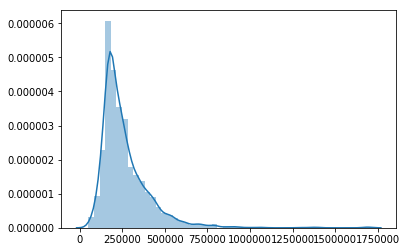

[Row(skewness(LISTPRICE)=2.790448093916559)]


In [16]:
# Select a single column and sample and convert to pandas
sample_df = df.select(['LISTPRICE']).sample(False, 0.5, 42)
pandas_df = sample_df.toPandas()

# Plot distribution of pandas_df and display plot
sns.distplot(pandas_df)
plt.show()

# Import skewness function
from pyspark.sql.functions import skewness

# Compute and print skewness of LISTPRICE
print(df.agg({'LISTPRICE': 'skewness'}).collect())